# TSP (Traveling Salesman Problem)
<br>

<center><img width = 30% src="https://web.colby.edu/thegeometricviewpoint/files/2014/11/map.png"/></center>

> **TSP**(Traveling Salesman Problem)는 한 정점에서 다른 모든 정점을 순회하여 다시 출발 정점으로 돌아오는 최적의 경로를 찾는 알고리즘이다.

## NP-Complete 문제 중 **TSP** 문제를 아래 세가지 방식으로 구현한 후 성능(수행시간)을 비교분석하라.
- (1) Naive 방법 (모든 경우 탐색)
- (2) Dynamic Programming 기법 사용
- (3) 유전자 알고리즘(Genetic Algorithm) 사용

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math
import time

In [2]:
N_list = [5, 6, 7, 8, 9, 10, 11]

graph_func = lambda N : np.random.randint(low=0, high=MAX_WEIGHT, size=(N, N))
max_distance_sum_func = lambda N : 2 * MAX_WEIGHT * N
MAX_WEIGHT = 20

Naive_time_list = []
DP_time_list = []
GA_time_list = []

INF = int(1e9)

### (1) Naive 방법 (모든 경우 탐색)

In [3]:
def TSP_Naive(x, visited, graph, naive):
    if visited == (1 << N) - 1:     # 모든 도시를 방문했다면
        if graph[x][0]:             # 출발점으로 가는 경로가 있을 때
            return graph[x][0]
        else:                       # 출발점으로 가는 경로가 없을 때
            return INF

    for i in range(1, N):           # 모든 도시를 탐방
        if not graph[x][i]:         # 가는 경로가 없다면 skip
            continue
        if visited & (1 << i):      # 이미 방문한 도시라면 skip
            continue

        # 점화식 부분
        naive[x][visited] = min(naive[x][visited], 
                                TSP_Naive(i, visited | (1 << i), graph, naive) + graph[x][i])

    return naive[x][visited]

### (2) Dynamic Programming 기법 사용

In [4]:
def TSP_DP(x, visited, graph, dp):
    if visited == (1 << N) - 1:     # 모든 도시를 방문했다면
        if graph[x][0]:             # 출발점으로 가는 경로가 있을 때
            return graph[x][0]
        else:                       # 출발점으로 가는 경로가 없을 때
            return INF

    if dp[x][visited] != INF:       # 이미 최소비용이 계산되어 있다면
        return dp[x][visited]

    for i in range(1, N):           # 모든 도시를 탐방
        if not graph[x][i]:         # 가는 경로가 없다면 skip
            continue
        if visited & (1 << i):      # 이미 방문한 도시라면 skip
            continue

        # 점화식 부분
        dp[x][visited] = min(dp[x][visited], TSP_DP(i, visited | (1 << i), graph, dp) + graph[x][i])

    return dp[x][visited]

### (3) 유전자 알고리즘(Genetic Algorithm) 사용

In [5]:
MIN_MUTATION_RATE = 0.01

# 유전자 알고리즘에서 염색체에 대한 이동 거리 계산
def TSP_distance(chromo):
    distance = graph[0][chromo[0]]
    loc = 0
    for gene in chromo:
        distance = distance + graph[chromo[loc]][chromo[loc+1]]
        loc += 1
        if loc == len(chromo)-1:
            return distance


# 경로가 짧을수록 MAX_DISTANCE_SUM에서 TSP_distance를 빼서 더 좋은(짧은) 경로에 더 많은 수를 할당한다.
# fitnessftn은 경로가 얼마나 짧은지를 나타내는 척도이다.
def fitnessftn(chromo):
    
    return(MAX_DISTANCE_SUM - TSP_distance(chromo))


# size개 만큼의 조상(부모)을 만듬
def init_population(num, size):
    populations_list = []

    for _ in range(size):
        # Generating random travelling paths.
        populations_list.append(np.random.choice(num, num, replace=False))

    return populations_list


# Roulette wheel selction 기법 사용
# 각 염색체의 적합도에 비례하는 만큼 roulette의 영역을 할당한 다음, roulette을 돌려 화살표가 가리키는 영역의 염색체를 선택
# 적합도가 높은 것은 선택된 확률이 그만큼 많고, 적합도가 낮은 것은 선택된 확률이 상대적으로 낮다.
def selection(population):
    fit_list = [fitnessftn(chromo) for chromo in population]
    total_fitness = sum(fit_list)

    randnum = random.random()  # 난수 생성
    index = 0
    fitsum = 0
    for fit in fit_list:
        fitsum += fit
        if randnum < (fitsum/total_fitness):
            break
        index += 1
    return population[index]


def crossover_with_mutation(parent1, parent2, mutation_rate=0.7):
    # 우선, child 배열에 parent 배열을 복사
    child1 = parent1.copy()
    child2 = parent2.copy()

    if random.random() < mutation_rate:  # 돌연변이 발생
        # 교차 (Crossover)
        random_index = random.randint(0, len(parent1)-1)

        # Single crossover (같은 인덱스 위치에서의 값을 교차하고, 중복되는 값을 겹치지 않게 처리해줌)
        child2[np.where(parent2 == parent1[random_index])] = parent2[random_index]
        child2[random_index] = parent1[random_index]

        child1[np.where(parent1 == parent2[random_index])] = parent1[random_index]
        child1[random_index] = parent2[random_index]

    else:
        pass

    return [child1, child2]


# 한 세대에서 경로들의 평균을 계산
def calc_avg_fitness(population, population_size):
    fit_list = [fitnessftn(chromo) for chromo in population]
    total_fitness = sum(fit_list)
    avg = total_fitness/population_size
    return avg


# 한 세대에서 경로들 중 최고의 경로를 찾아냄
def best_chro(population):
    MINFIT = -1000
    best_index = 0
    index = 0
    best_fit = MINFIT

    for chromo in population:
        fit = fitnessftn(chromo)

        if best_fit < fit:
            best_index = index
            best_fit = fit

        index += 1

    return population[best_index]


def element_in_list(ele, alist):
    for i in alist:
        if ele == i:
            return 1
    return 0


# population에서 가장 좋은 염색체의 인덱스를 찾음
def best_chromsome_index(chromsome_list, exceptlist):
    MINFIT = -1000
    best_index = 0
    index = 0
    best_fit = MINFIT

    for chromo in chromsome_list:
        if element_in_list(index, exceptlist) == 1:
            index += 1
            continue
        fit = fitnessftn(chromo)
        if best_fit < fit:
            best_index = index
            best_fit = fit
        index += 1
    return best_index


# 한 generation에 생산된 가장 좋은 염색체 또는 가장 짧은 경로의 인덱스를 수집
def elite_chromsome_index(chromsome_list, num):
    result = []
    for i in range(0, num):
        best_index = best_chromsome_index(chromsome_list, result)
        result.append(best_index)
    return result

In [20]:
# population_size : 한 세대의 인구 크기
# num_gen : 유전자의 수
# mutation_rate : 돌연변이율
# elite_num : 다음 세대에 전달할 우수한 염색체의 수 (홀수이면 오류가 날 수 있다.)
# Genetic Algorithm _ The Shortest Path

def TSP_GA(N, population_size, num_gen, mutation_rate=0.7, elite_num=0):
    start_sec = time.time()

    global graph;
    graph = graph_func(N)
    global MAX_DISTANCE_SUM; 
    MAX_DISTANCE_SUM = max_distance_sum_func(N);

    old_gen = init_population(N, population_size)  # 최초 Population을 만듦
    best_path = best_chro(old_gen)  # 1등 염색체를 찾아내는 과정
    best_sec = time.time() - start_sec
    best_g_num = 0

    # 최초 generation의 평균 fitness 값을 표시
    print(f"Average Fitness of First Gen = {calc_avg_fitness(old_gen, population_size)}")
    # 최초 generation의 최고 염색체의 fitness 값을 표시
    print(f"   Best Fitness of First Gen = {fitnessftn(best_path)} (Cost : {TSP_distance(best_path)}, Path : {best_path})")

    # 결혼시킬 쌍(커플)의 수, 전체 population에서 복제하려는 수를 빼주고 2로 나누어줘야 함
    crossoverpairs_num = int((population_size - elite_num)/2)
    best_avg_fitness = calc_avg_fitness(old_gen, population_size)

    best_g_num = 0
    for g in range(0, num_gen):
        new_gen = []

        elites = []
        elite_index_list = elite_chromsome_index(old_gen, elite_num)

        for elite_index in elite_index_list:
            new_gen.append(old_gen[elite_index])

        for _ in range(crossoverpairs_num):
            crossovered = crossover_with_mutation(
                selection(old_gen), selection(old_gen), mutation_rate)
            new_gen.extend(crossovered)
        
        avg_fit = calc_avg_fitness(new_gen, population_size)
        if avg_fit > best_avg_fitness:
            best_avg_fitness = avg_fit
            # print(f"Average Fitness of Gen {g+1} = {avg_fit}")

        best_path_new_gen = best_chro(new_gen)
        if fitnessftn(best_path_new_gen) > fitnessftn(best_path):
            best_path = best_path_new_gen.copy()
            print(f"   Best Fitness at Gen {g+1} = {fitnessftn(best_path)} (Cost : {TSP_distance(best_path)}, Path : {best_path})")
            best_g_num = g+1
            best_sec = time.time() - start_sec

        old_gen = new_gen

    print("--------------------------------------------------------------")
    print(f"==> During {g+1} Generations, Best Path {best_path}")
    print(f"==> at Gen {best_g_num}, {round(best_sec, 4)} sec (Fitness : {fitnessftn(best_path)}, Cost : {TSP_distance(best_path)})")

    return [best_g_num, best_sec, fitnessftn(best_path), TSP_distance(best_path)]

### 실험 1) N값과 알고리즘에 따른 TSP의 실행시간 비교

#### 실험 1-1) Naive Algorithm과 Dynamic Programming의 비교

In [7]:
for N in N_list:
    print(f"================== N = {N} ==================")

    # 임의의 비용 행렬 생성
    graph = graph_func(N)

    for n in range(N):
        graph[n][n] = 0

    print("(1) 모든 경우를 탐색하는 Naive 방법을 사용한 TSP 문제 해결")
    naive = [[INF] * (1 << N) for _ in range(N)]  # 1<<N은 2^N의 값과 같다.
                                                  # 크기가 (2^N, N)인 행렬

    start = time.time()
    print(f"(N = {N}) Naive의 최솟값 결과 : {TSP_Naive(0, 1, graph, naive)}")
    end = time.time() - start
    Naive_time_list.append(round(end, 4))
    print(f"(N = {N}) 소요 시간 : {Naive_time_list[-1]} sec")
    print()

    print("(2) Dynamic Programming 기법을 사용한 TSP 문제 해결")
    dp = [[INF] * (1 << N) for _ in range(N)]  # 1<<N은 2^N의 값과 같다.
                                               # 크기가 (2^N, N)인 행렬

    start = time.time()
    print(f"(N = {N}) DP의 최솟값 결과 : {TSP_DP(0, 1, graph, dp)}")
    end = time.time() - start
    DP_time_list.append(round(end, 4))
    print(f"(N = {N}) 소요 시간 : {DP_time_list[-1]} sec")
    print()

12181879 이동건
================== N = 5 ==================
(1) 모든 경우를 탐색하는 Naive 방법을 사용한 TSP 문제 해결
(N = 5) Naive의 최솟값 결과 : 17
(N = 5) 소요 시간 : 0.0002 sec

(2) Dynamic Programming 기법을 사용한 TSP 문제 해결
(N = 5) DP의 최솟값 결과 : 17
(N = 5) 소요 시간 : 0.0002 sec

================== N = 6 ==================
(1) 모든 경우를 탐색하는 Naive 방법을 사용한 TSP 문제 해결
(N = 6) Naive의 최솟값 결과 : 35
(N = 6) 소요 시간 : 0.0007 sec

(2) Dynamic Programming 기법을 사용한 TSP 문제 해결
(N = 6) DP의 최솟값 결과 : 35
(N = 6) 소요 시간 : 0.0004 sec

================== N = 7 ==================
(1) 모든 경우를 탐색하는 Naive 방법을 사용한 TSP 문제 해결
(N = 7) Naive의 최솟값 결과 : 37
(N = 7) 소요 시간 : 0.0032 sec

(2) Dynamic Programming 기법을 사용한 TSP 문제 해결
(N = 7) DP의 최솟값 결과 : 37
(N = 7) 소요 시간 : 0.001 sec

================== N = 8 ==================
(1) 모든 경우를 탐색하는 Naive 방법을 사용한 TSP 문제 해결
(N = 8) Naive의 최솟값 결과 : 32
(N = 8) 소요 시간 : 0.0486 sec

(2) Dynamic Programming 기법을 사용한 TSP 문제 해결
(N = 8) DP의 최솟값 결과 : 32
(N = 8) 소요 시간 : 0.0029 sec

================== N = 9 ==================
(1) 모든 경우를 탐

##### 실험 1-1의 결과

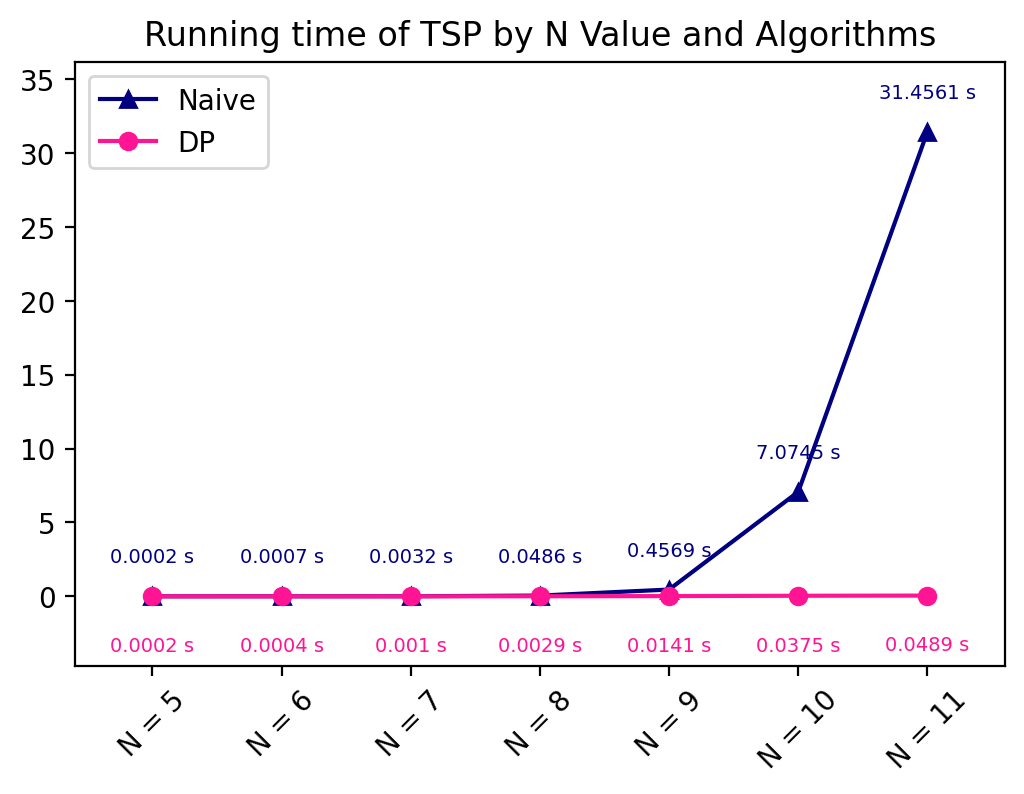

In [15]:
plt.figure(dpi=200)
plt.title("Running time of TSP by N Value and Algorithms")

plt.plot(N_list, Naive_time_list, marker='^', label="Naive", color="navy")
for i in range(len(N_list)):
    time_val = Naive_time_list[i]
    plt.text(N_list[i], time_val + 2, f'{time_val} s',
             ha='center', va='bottom', size=7, color="navy")

plt.plot(N_list, DP_time_list, marker='o', label="DP", color="deeppink")
for i in range(len(N_list)):
    time_val = DP_time_list[i]
    plt.text(N_list[i], time_val - 4, f'{time_val} s',
             ha='center', va='bottom', size=7, color="deeppink")

x_label = [f"N = {N}" for N in N_list]
plt.xticks(ticks=N_list, labels=x_label, rotation=45)
plt.legend(loc="upper left")
plt.margins(0.1, 0.15, tight=True)
plt.show()

#### 실험 1-2) 유전 알고리즘에서의 N값에 따른 성능 비교 (최고 성능이 나온 세대, 시간)

In [28]:
best_gen_list = []
best_sec_list = []
best_fit_list = []
best_cost_list = []
GA_time_list = []

for N in N_list:
    population_size = 50
    num_gen = 100
    mutation_rate = 0.1
    elite_num = 5

    print(f"============================ N = {N} ============================")
    print(f"======= Population Size : {population_size},   Num of Generations : {num_gen} ======")
    print(f"=======   Mutation Rate : {mutation_rate}, Num of Elite : {elite_num}          ======")
    
    start = time.time()
    best_result = TSP_GA(N, population_size, num_gen, mutation_rate, elite_num)
    
    end = time.time() - start

    best_gen_list.append(best_result[0])
    best_sec_list.append(round(best_result[1], 4))
    best_fit_list.append(best_result[2])
    best_cost_list.append(best_result[3])
    GA_time_list.append(round(end, 4))
    
    print(f"==> Total Running Time : {GA_time_list[-1]} sec")
    print()
    print()

============================ N = 5 ============================
======= Population Size : 50,   Num of Generations : 100 ======
=======   Mutation Rate : 0.1, Num of Elite : 5          ======
Average Fitness of First Gen = 165.14
   Best Fitness of First Gen = 186 (Cost : 14, Path : [3 0 1 4 2])
--------------------------------------------------------------
==> During 100 Generations, Best Path [3 0 1 4 2]
==> at Gen 0, 0.001 sec (Fitness : 186, Cost : 14)
==> Total Running Time : 1.0614 sec


============================ N = 6 ============================
======= Population Size : 50,   Num of Generations : 100 ======
=======   Mutation Rate : 0.1, Num of Elite : 5          ======
Average Fitness of First Gen = 182.14
   Best Fitness of First Gen = 205 (Cost : 35, Path : [5 3 1 2 4 0])
   Best Fitness at Gen 1 = 207 (Cost : 33, Path : [4 2 0 5 3 1])
   Best Fitness at Gen 6 = 208 (Cost : 32, Path : [2 4 0 5 3 1])
--------------------------------------------------------------
==> Durin

##### 실험 1-2의 결과

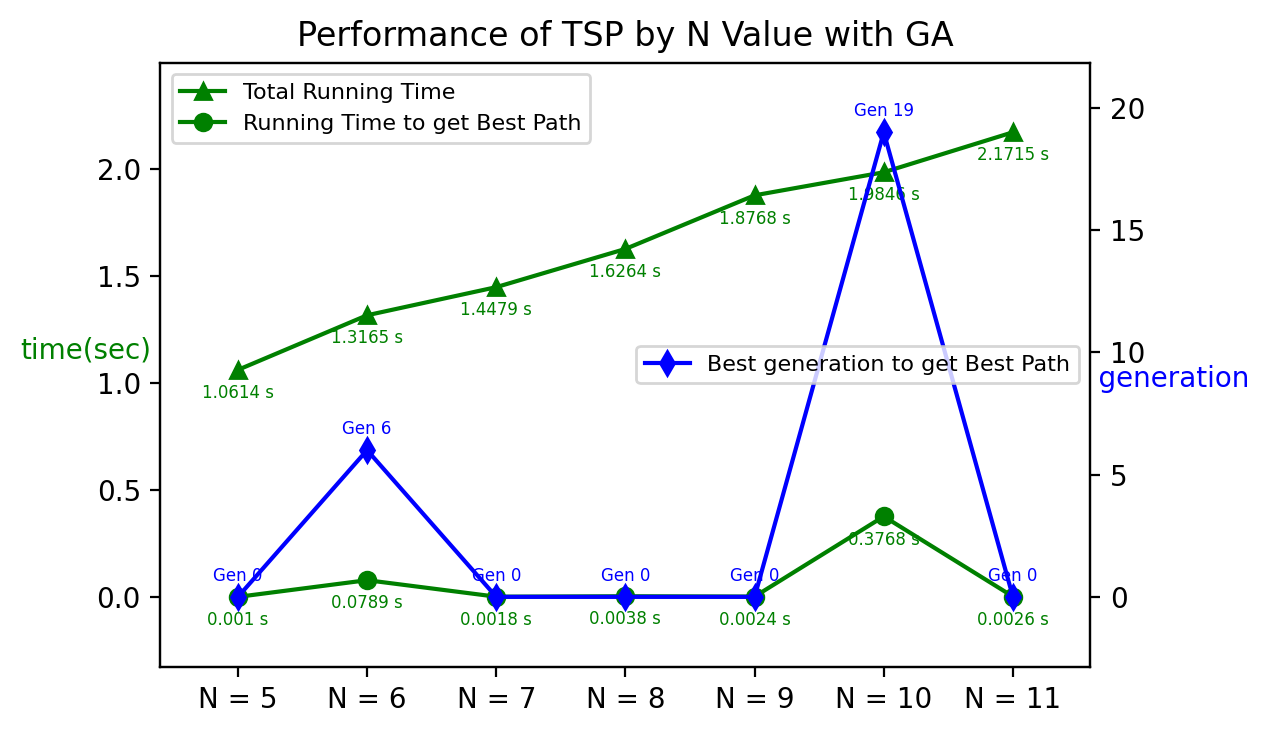

In [34]:
fig, ax1 = plt.subplots(dpi=200)
ax1.set_title("Performance of TSP by N Value with GA")
ax1.set_ylabel('time(sec)', color = 'green', rotation = 0)

ax1.plot(N_list, GA_time_list, marker='^', label="Total Running Time", color="green")
for i in range(len(N_list)):
    time_val = GA_time_list[i]
    ax1.text(N_list[i], time_val - 0.15, f'{time_val} s',
             ha='center', va='bottom', size=6, color="green")

ax1.plot(N_list, best_sec_list, marker='o', label="Running Time to get Best Path", color="green")
for i in range(len(N_list)):
    time_val = best_sec_list[i]
    ax1.text(N_list[i], time_val - 0.15, f'{time_val} s',
             ha='center', va='bottom', size=6, color="green")


ax2 = ax1.twinx()
ax2.set_ylabel('    generation', color = 'blue', rotation = 0)
ax2.plot(N_list, best_gen_list, marker='d', label="Best generation to get Best Path", color="blue")
for i in range(len(N_list)):
    gen_val = best_gen_list[i]
    ax2.text(N_list[i], gen_val+0.5, f'Gen {gen_val}',
             ha='center', va='bottom', size=6, color="blue")


x_label = [f"N = {N}" for N in N_list]
plt.xticks(ticks=N_list, labels=x_label, rotation=45)
ax1.legend(loc="upper left", fontsize=8)
ax2.legend(loc="center right", fontsize=8)
ax1.margins(0.1, 0.15, tight=True)
ax2.margins(0.1, 0.15, tight=True)

plt.show()

#### 실험 1-3) N값과 알고리즘에 따른 TSP의 실행시간 비교 (Naive, DP, GA) 

##### 실험 1-3 결과

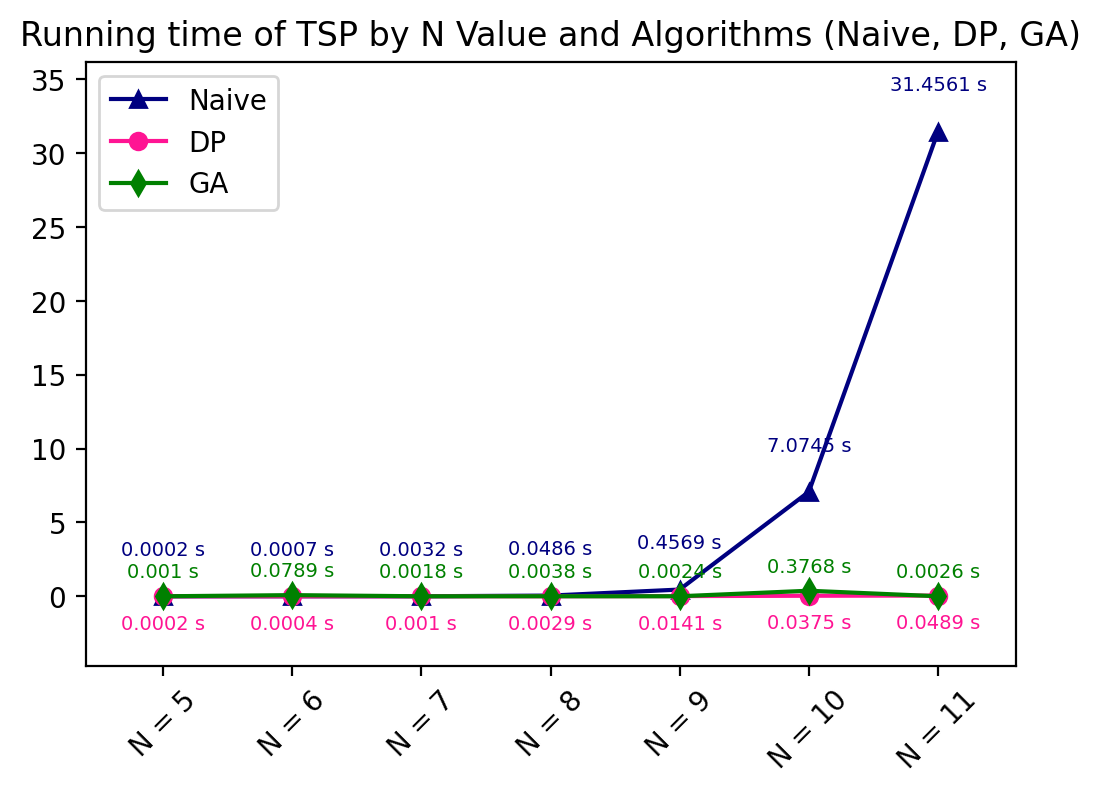

In [37]:
plt.figure(dpi=200)

plt.title("Running time of TSP by N Value and Algorithms (Naive, DP, GA)")

plt.plot(N_list, Naive_time_list, marker='^', label="Naive", color="navy")
for i in range(len(N_list)):
    time_val = Naive_time_list[i]
    plt.text(N_list[i], time_val + 2.5, f'{time_val} s',
             ha='center', va='bottom', size=7, color="navy")

plt.plot(N_list, DP_time_list, marker='o', label="DP", color="deeppink")
for i in range(len(N_list)):
    time_val = DP_time_list[i]
    plt.text(N_list[i], time_val - 2.5, f'{time_val} s',
             ha='center', va='bottom', size=7, color="deeppink")
    
plt.plot(N_list, best_sec_list, marker='d', label="GA", color="green")
for i in range(len(N_list)):
    time_val = best_sec_list[i]
    plt.text(N_list[i], time_val + 1, f'{time_val} s',
             ha='center', va='bottom', size=7, color="green")

x_label = [f"N = {N}" for N in N_list]
plt.xticks(ticks=N_list, labels=x_label, rotation=45)
plt.legend(loc="upper left")
plt.margins(0.1, 0.15, tight=True)
plt.show()

### 실험 2) N = 40일 때, `mutation_rate`에 따른 성능 비교

In [91]:
best_gen_list = []
best_sec_list = []
best_fit_list = []
best_cost_list = []
GA_time_list = []

mutation_list = np.linspace(0.001, 0.01, 6) # 0.001부터 0.01까지 11개 구간으로 나눈 실수 생성
for mutation_rate in mutation_list:
    N = 40
    population_size = 100
    num_gen = 40
    elite_num = 5
    
    print(f"============================ N = {N} ============================")
    print(f"======= Population Size : {population_size},   Num of Generations : {num_gen} ======")
    print(f"=======   Mutation Rate : {round(mutation_rate, 3)}, Num of Elite : {elite_num}          ======")


    start = time.time()
    best_result = TSP_GA(N, population_size, num_gen, mutation_rate, elite_num)
    
    end = time.time() - start

    best_gen_list.append(best_result[0])
    best_sec_list.append(round(best_result[1], 4))
    best_fit_list.append(best_result[2])
    best_cost_list.append(best_result[3])
    GA_time_list.append(round(end, 4))
    
    print(f"==> Total Running Time : {GA_time_list[-1]} sec")
    print()
    print()

============================ N = 40 ============================
======= Population Size : 100,   Num of Generations : 40 ======
=======   Mutation Rate : 0.001, Num of Elite : 5          ======
Average Fitness of First Gen = 1227.05
   Best Fitness of First Gen = 1334 (Cost : 266, Path : [13 29 31 32 37  5 19 11  9  8 23 10 14 34 21 12 18 36 16  0  2 26  3 20
 38 17 24 39 25 15  1 33 30 27 28  7  4  6 22 35])
--------------------------------------------------------------
==> During 40 Generations, Best Path [13 29 31 32 37  5 19 11  9  8 23 10 14 34 21 12 18 36 16  0  2 26  3 20
 38 17 24 39 25 15  1 33 30 27 28  7  4  6 22 35]
==> at Gen 0, 0.0116 sec (Fitness : 1334, Cost : 266)
==> Total Running Time : 12.5076 sec


============================ N = 40 ============================
======= Population Size : 100,   Num of Generations : 40 ======
=======   Mutation Rate : 0.003, Num of Elite : 5          ======
Average Fitness of First Gen = 1233.88
   Best Fitness of First Gen = 1324 

##### 실험 2 결과

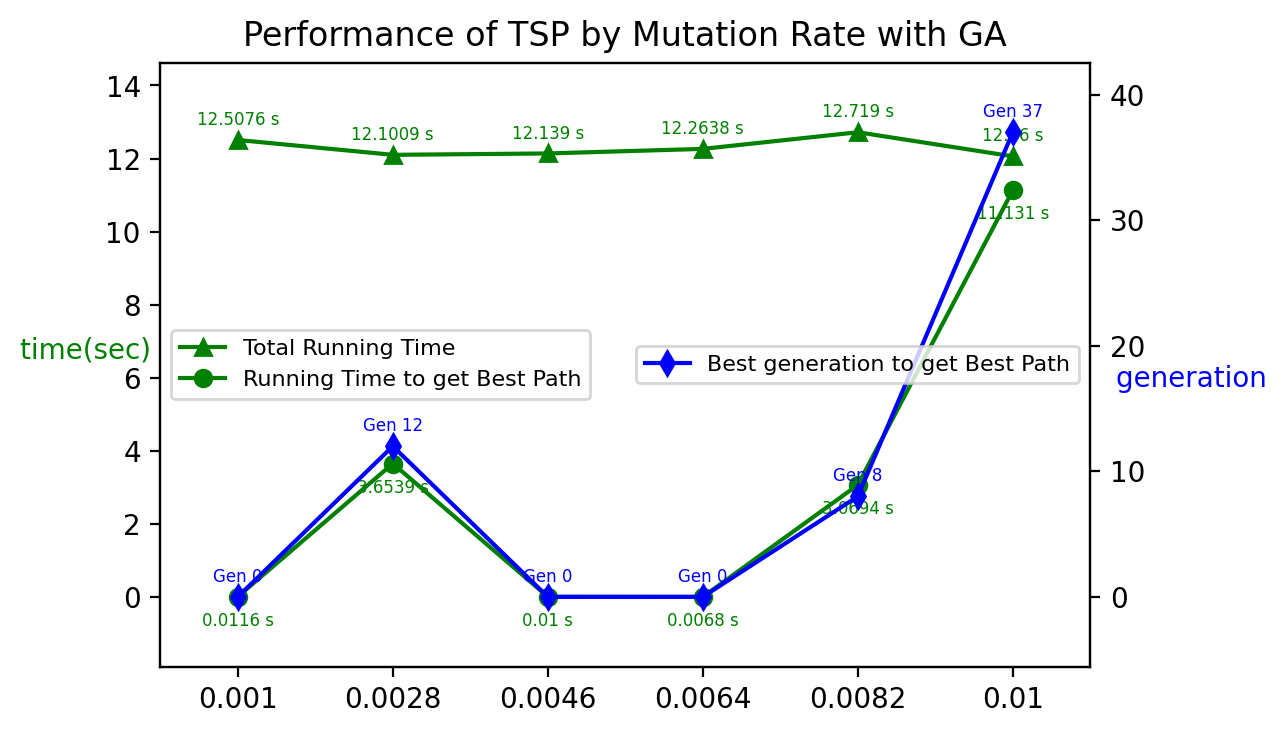

In [100]:
fig, ax1 = plt.subplots(dpi=200)
ax1.set_title("Performance of TSP by Mutation Rate with GA")
ax1.set_ylabel('time(sec)  ', color = 'green', rotation = 0)

ax1.plot(mutation_list, GA_time_list, marker='^', label="Total Running Time", color="green")
for i in range(len(mutation_list)):
    time_val = GA_time_list[i]
    ax1.text(mutation_list[i], time_val + 0.3, f'{time_val} s',
             ha='center', va='bottom', size=6, color="green")

ax1.plot(mutation_list, best_sec_list, marker='o', label="Running Time to get Best Path", color="green")
for i in range(len(mutation_list)):
    time_val = best_sec_list[i]
    ax1.text(mutation_list[i], time_val - 0.9, f'{time_val} s',
             ha='center', va='bottom', size=6, color="green")


ax2 = ax1.twinx()
ax2.set_ylabel('        generation', color = 'blue', rotation = 0)
ax2.plot(mutation_list, best_gen_list, marker='d', label="Best generation to get Best Path", color="blue")
for i in range(len(mutation_list)):
    gen_val = best_gen_list[i]
    ax2.text(mutation_list[i], gen_val+0.9, f'Gen {gen_val}',
             ha='center', va='bottom', size=6, color="blue")


x_label = [f"{round(rate, 5)}" for rate in mutation_list]
plt.xticks(ticks=mutation_list, labels=x_label, rotation=90, fontsize=2)
ax1.legend(loc="center left", fontsize=8)
ax2.legend(loc="center right", fontsize=8)
ax1.margins(0.1, 0.15, tight=True)
ax2.margins(0.1, 0.15, tight=True)

plt.show()

### 실험 3) N = 40일 때, elite_num에 따른 성능 비교

In [112]:
best_gen_list = []
best_sec_list = []
best_fit_list = []
best_cost_list = []
GA_time_list = []

population_size = 50
elite_list = [e for e in range(0, num_gen+1, 10)]  # 0부터 num_gen까지 10을 간격으로 나눈 실수 생성
for elite_num in elite_list:
    N = 40
    num_gen = 50
    mutation_rate = 0.01

    print(f"=========================== N = {N} ============================")
    print(f"======= Population Size : {population_size},   Num of Generations : {num_gen} =======")
    print(f"=======   Mutation Rate : {mutation_rate}, Num of Elite : {elite_num}        ======")
    
    start = time.time()
    best_result = TSP_GA(N, population_size, num_gen, mutation_rate, elite_num)
    
    end = time.time() - start

    best_gen_list.append(best_result[0])
    best_sec_list.append(round(best_result[1], 4))
    best_fit_list.append(best_result[2])
    best_cost_list.append(best_result[3])
    GA_time_list.append(round(end, 4))
    
    print(f"==> Total Running Time : {GA_time_list[-1]} sec")
    print()
    print()

=========================== N = 40 ============================
======= Population Size : 50,   Num of Generations : 50 =======
=======   Mutation Rate : 0.01, Num of Elite : 0        ======
Average Fitness of First Gen = 1220.32
   Best Fitness of First Gen = 1303 (Cost : 297, Path : [ 1  7 32  4  9  5  6 37 23 27 13 35 33 24 15 11 31 34 39  8 25 19 20 10
  3 16 14 12 21 26 28 36 22 30 18  2 38  0 17 29])
--------------------------------------------------------------
==> During 50 Generations, Best Path [ 1  7 32  4  9  5  6 37 23 27 13 35 33 24 15 11 31 34 39  8 25 19 20 10
  3 16 14 12 21 26 28 36 22 30 18  2 38  0 17 29]
==> at Gen 0, 0.0037 sec (Fitness : 1303, Cost : 297)
==> Total Running Time : 3.9845 sec


=========================== N = 40 ============================
======= Population Size : 50,   Num of Generations : 50 =======
=======   Mutation Rate : 0.01, Num of Elite : 10        ======
Average Fitness of First Gen = 1233.56
   Best Fitness of First Gen = 1318 (Cost : 

##### 실험 3 결과

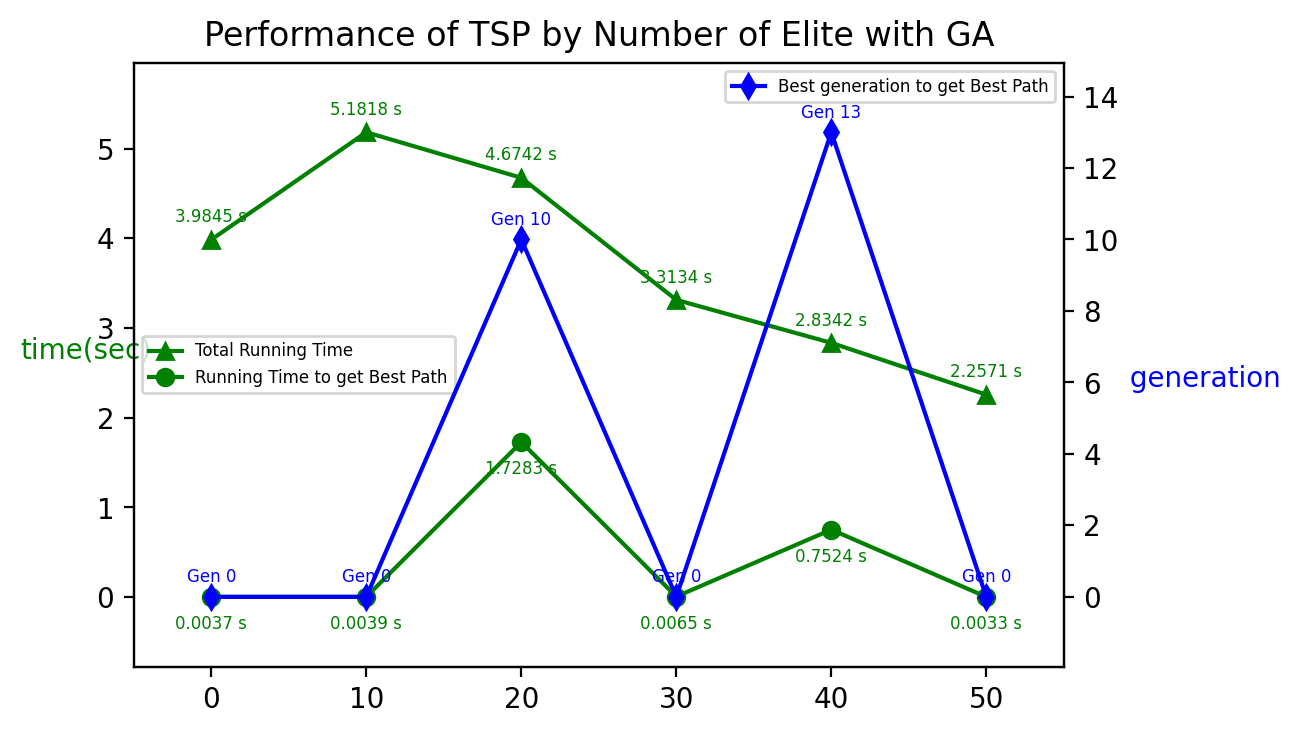

In [121]:
fig, ax1 = plt.subplots(dpi=200)
ax1.set_title("Performance of TSP by Number of Elite with GA")
ax1.set_ylabel('time(sec)', color = 'green', rotation = 0)

ax1.plot(elite_list, GA_time_list, marker='^', label="Total Running Time", color="green")
for i in range(len(elite_list)):
    time_val = GA_time_list[i]
    ax1.text(elite_list[i], time_val+0.15, f'{time_val} s',
             ha='center', va='bottom', size=6, color="green")

ax1.plot(elite_list, best_sec_list, marker='o', label="Running Time to get Best Path", color="green")
for i in range(len(elite_list)):
    time_val = best_sec_list[i]
    ax1.text(elite_list[i], time_val - 0.4, f'{time_val} s',
             ha='center', va='bottom', size=6, color="green")


ax2 = ax1.twinx()
ax2.set_ylabel('                 generation', color = 'blue', rotation = 0)
ax2.plot(elite_list, best_gen_list, marker='d', label="Best generation to get Best Path", color="blue")
for i in range(len(elite_list)):
    gen_val = best_gen_list[i]
    ax2.text(elite_list[i], gen_val+0.3, f'Gen {gen_val}',
             ha='center', va='bottom', size=6, color="blue")


x_label = [f"{round(rate, 4)}" for rate in elite_list]
plt.xticks(ticks=elite_list, labels=x_label, rotation=90, fontsize=5)
ax1.legend(loc="center left", fontsize=6)
ax2.legend(loc="upper right", fontsize=6)
ax1.margins(0.1, 0.15, tight=True)
ax2.margins(0.1, 0.15, tight=True)

plt.show()